# Transfer Learning with InceptionV3 on CIFAR-10 in Keras

Imports

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing import image
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from keras.models import Model
from keras.layers import UpSampling2D, Flatten

# Pretrained model loading

In [2]:
conv_base = InceptionV3(weights = 'imagenet', include_top = False, input_shape=(224, 224, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
conv_base.input

<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [4]:
for layer in conv_base.layers:
  print(layer)

<InputLayer name=input_layer, built=True>
<Conv2D name=conv2d, built=True>
<BatchNormalization name=batch_normalization, built=True>
<Activation name=activation, built=True>
<Conv2D name=conv2d_1, built=True>
<BatchNormalization name=batch_normalization_1, built=True>
<Activation name=activation_1, built=True>
<Conv2D name=conv2d_2, built=True>
<BatchNormalization name=batch_normalization_2, built=True>
<Activation name=activation_2, built=True>
<MaxPooling2D name=max_pooling2d, built=True>
<Conv2D name=conv2d_3, built=True>
<BatchNormalization name=batch_normalization_3, built=True>
<Activation name=activation_3, built=True>
<Conv2D name=conv2d_4, built=True>
<BatchNormalization name=batch_normalization_4, built=True>
<Activation name=activation_4, built=True>
<MaxPooling2D name=max_pooling2d_1, built=True>
<Conv2D name=conv2d_8, built=True>
<BatchNormalization name=batch_normalization_8, built=True>
<Activation name=activation_8, built=True>
<Conv2D name=conv2d_6, built=True>
<Conv2D

Freezing Layers

In [5]:
# don't train existing layers
for layer in conv_base.layers:
  layer.trainable = False

In [6]:
for layer in conv_base.layers:
  print(layer.name, layer.trainable)

input_layer False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
acti

In [7]:
conv_base.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

# Loading the CIFAR-10 dataset

In [8]:
(X_train, y_train), (X_test, y_test)=cifar10.load_data()
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(X_train.shape)
print(X_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


# Model Architecture

In [9]:
from tensorflow.keras.layers import Resizing

model = models.Sequential()

model.add(layers.UpSampling2D((2, 2))) #32*2 =64
model.add(layers.UpSampling2D((2, 2))) #64*2 =128
model.add(layers.UpSampling2D((2, 2))) #128*2 =256

model.add(Resizing(224, 224, interpolation='bilinear'))
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ up_sampling2d (UpSampling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

# Model Compilation and training

In [14]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer = RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, steps_per_epoch=10, epochs=20, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.6024 - loss: 1.2326 - val_accuracy: 0.7249 - val_loss: 0.8581
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5968 - loss: 1.1325 - val_accuracy: 0.7328 - val_loss: 0.8228
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6674 - loss: 0.9179 - val_accuracy: 0.7383 - val_loss: 0.8161
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6879 - loss: 0.9992 - val_accuracy: 0.7546 - val_loss: 0.7910
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6702 - loss: 1.0087 - val_accuracy: 0.7568 - val_loss: 0.7862
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6482 - loss: 0.9603 - val_accuracy: 0.7581 - val_loss: 0.7908
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7321 - loss: 0.8048 - val_accuracy: 0.7578 - val_loss: 0.8039
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6525 - loss: 1.0963 - val_accuracy: 0.7558 - val_loss:

# Visualization

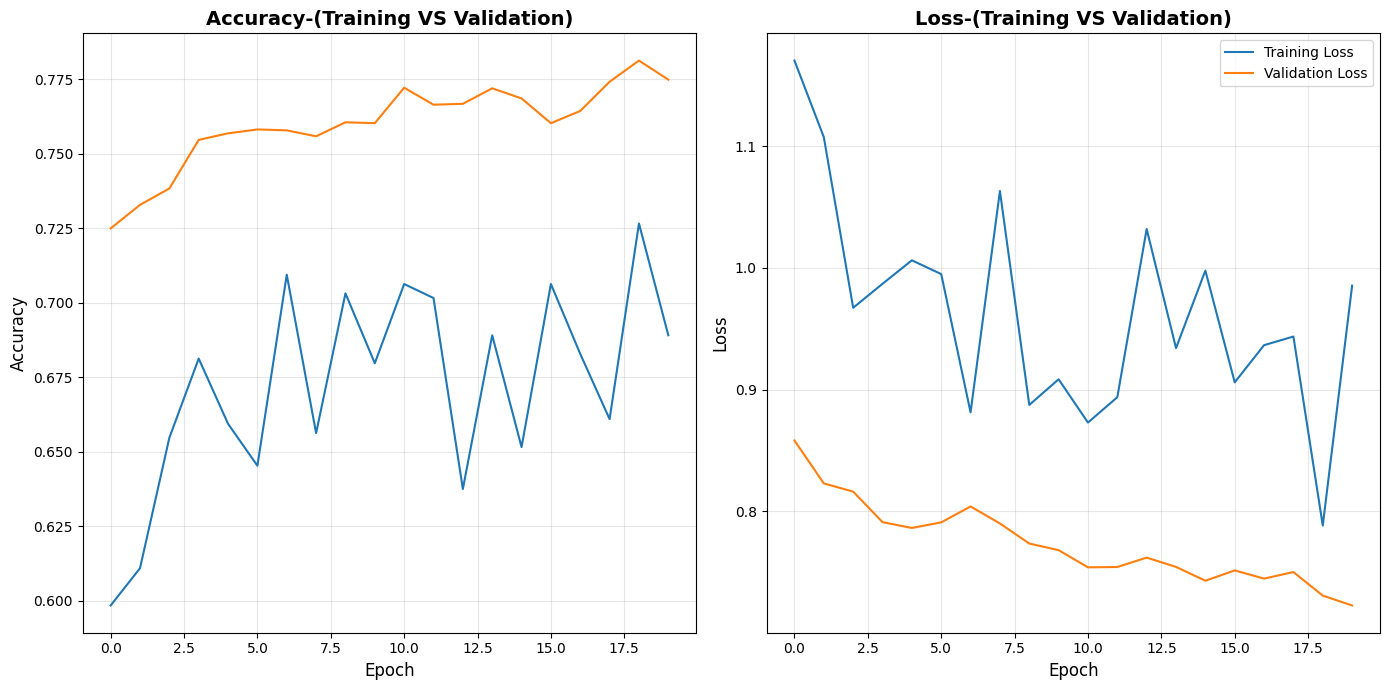

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

#Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_title("Accuracy-(Training VS Validation)", fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

#Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Loss", fontsize=12)
ax2.set_title("Loss-(Training VS Validation)", fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.legend()
plt.tight_layout()
plt.show()

# Save & Load the model

In [17]:
model.save("cifar_model.h5")

Input Dimensions - Image :  (500, 500, 3)


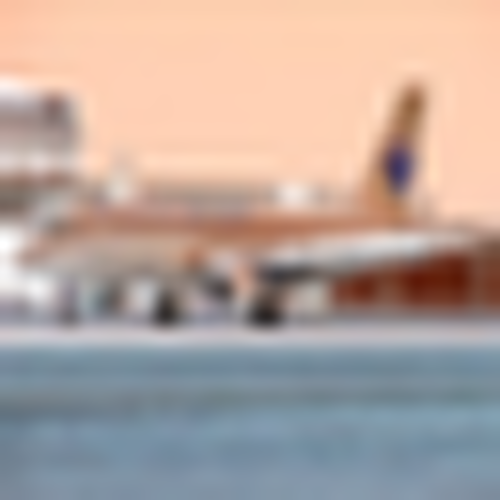

In [18]:
from matplotlib.pyplot import imshow
import cv2
from google.colab.patches import cv2_imshow
from skimage import io

input_img= "http://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane1.png"

input_img = io.imread(input_img)
#scale up to meet the size requirements.
#If you are enlarging the image, you should prefer to use INTER_LINEAR or INTER_CUBIC interpolation.
#If you are shrinking the image, you should prefer to use INTER_AREA interpolation.Cubic interpolation is computationally more complex, and hence slower than linear interpolation.
#However, the quality of the resulting image will be higher.
input_img = cv2.resize(input_img, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
print('Input Dimensions - Image : ',input_img.shape)
cv2_imshow(input_img)

In [19]:
import numpy as np
import keras.utils as image

input_img = cv2.resize(input_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
x = image.img_to_array(input_img) #Converts a PIL Image instance to a Numpy array.
x = np.expand_dims(x, axis=0)     # converting into 1 dimensional array
x = preprocess_input(x)           #The preprocess_input function is meant to adequate your image to the format the model requires.
preds = model.predict(x)
class_idx = np.argmax(preds[0])

preds[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


array([6.2968808e-01, 2.3042290e-04, 2.2472872e-01, 2.7391909e-02,
       3.3848051e-02, 7.4504453e-05, 9.0440167e-03, 4.4331216e-07,
       7.4983366e-02, 1.0249342e-05], dtype=float32)

In [22]:
class_idx

np.int64(0)

In [ ]:
# 0 : airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck